# Tarea 1, parte 2

De Sirianni et al. (2015), podemos transformar de los filtros F555W y F814 utilizando la siguiente función.


In [1]:
def trans_to_UVBRI(sf555, sf814, f555_zp, f814_zp, f555_av, f814_av):
    # Primero le quitamos el zero point
    sf555 -= f555_zp
    sf814 -= f814_zp
    
    # Ahora el reddening
    sf555 += f555_av
    sf814 += f814_av   
    
    # Coeficientes para transformar de f555 a V.
    c0v = [25.250, 25.275]
    c1v = [-0.09, -0.124]
    c2v = [0.034, 0.018]
    
    # Coeficientes para transformar de f814 a I.
    c0i = [24.837, 24.838]
    c1i = [0.060, 0.001]
    c2i = [-0.099, 0.013]
    
    # Para una primera aproximación
    mag_v = sf555
    mag_i = sf814
    
    for _ in range(0, 10):
        tcol = mag_v - mag_i
        # Tomamos los índices según el rango de TCOl.
        idv = 0 if tcol < 0.6 else 1
        idi = 0 if tcol < 0.1 else 1
        
        mag_v = sf555 + c0v[idv] + c1v[idv]*tcol + c2v[idv]*(tcol)**2
        mag_i = sf814 + c0i[idi] + c1i[idi]*tcol + c2i[idi]*(tcol)**2

    # Agregamos el reddening:
    mag_v -= 0.101
    mag_i -= 0.056
    return (mag_v, mag_i)

Aplicamos esta transformación a los datos de la parte 1.

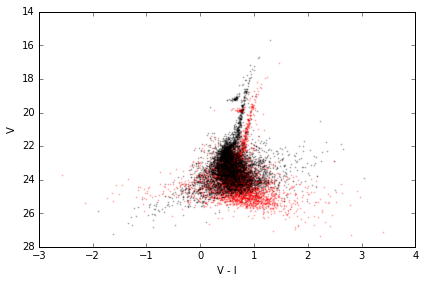

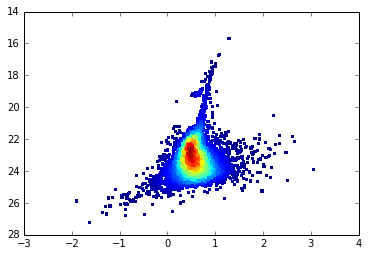

In [2]:
from scipy.stats import gaussian_kde
import tarea1_parte1
import numpy as np


Tarea1 = tarea1_parte1.Tarea1Parte1()

mag = zip(Tarea1.f555_mag, Tarea1.f814_mag)
params = (Tarea1.f555_zp, Tarea1.f814_zp, Tarea1.f555_av, Tarea1.f555_av)
mag = list(map(lambda x: trans_to_UVBRI(x[0], x[1], *params), mag))

%matplotlib inline
import matplotlib.pyplot as plt

axis_x = list(map(lambda x: x[0]-x[1], mag))
_, axis_y = zip(*mag)

plt.scatter(np.array(Tarea1.f555_mag) - np.array(Tarea1.f814_mag), Tarea1.f555_mag, marker='o', color='Red', s=1, alpha=0.2)
plt.scatter(axis_x, axis_y, marker='o', c='Black', s=1, alpha=0.2)
plt.xlabel('V - I')
plt.ylabel('V')
plt.tight_layout()
axes = plt.gca()
axes.invert_yaxis()
#axes.set_xlim([0.7, 0.9])
#axes.set_ylim([27, 16])
plt.show()

x = axis_x
y = axis_y

# Código adaptado del amigo de stackoverflow: 
# http://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=10, marker='s', edgecolor='')
axes = plt.gca()
axes.invert_yaxis()
plt.show()

Buscamos una isócrona para NGC 121, que tiene una edad de [10.5 Gyr](http://iopscience.iop.org/article/10.1088/0004-6256/135/4/1106/pdf):

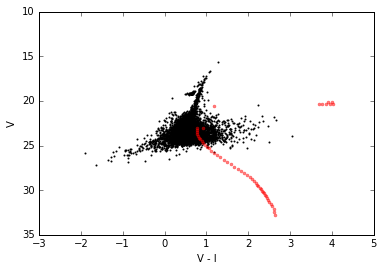

In [9]:
from isochrones.dartmouth import Dartmouth_Isochrone
import numpy as np
isochrone = Dartmouth_Isochrone(['V','I'])
age = np.log10(10.5*(10**9))
distance = 61000
a_v = [0.101, 0.056]
model = isochrone.isochrone(age)
mod = 5*np.log10(distance/10)


model_y = model.V_mag + mod+a_v[0]
model_x = model.V_mag - model.I_mag + a_v[0] - a_v[1]


plt.plot(model_x, model_y,'r.',alpha=0.5)

axes = plt.gca()
axes.invert_yaxis()
plt.xlabel('V - I')
plt.ylabel('V')

plt.scatter(x, y, marker='o', c='Black', s=1)
plt.show()